In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.text import Text
import seaborn as sns; sns.set_style("white")
import plotly.graph_objects as go
%matplotlib inline

from pycytominer import feature_select

# Set current working directory
# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D/spher_colo52_v1')
print(os.getcwd())

# cell_line = "SW620"

/share/data/analyses/christa/colopaint3D/spher_colo52_v1
/share/data/analyses/christa/colopaint3D/spher_colo52_v1


pip install -U kaleido 

In [15]:
# Set up the plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
dpi = 300
figformat = 'pdf'

In [16]:
cell_line = 'HCT116'
data_type = 'aggregates'

In [17]:
# Load the data
file = 'selected_data_all_grit.csv'
data = pd.read_csv(file)

In [18]:
OutputDir = '3_Radarplots/result-images'

In [19]:
## Prepare the metadata for the grit calculation
dataset_aggregated = data.query("Metadata_cell_line == @cell_line & Metadata_data_type == @data_type").copy()


# Add a column with the step of the concentration (easier for plotting)
dataset_aggregated['Metadata_conc_step'] = (
    dataset_aggregated.groupby('Metadata_cmpdname')['Metadata_cmpd_conc'].rank(ascending=True, method='dense')
    )
# Add a column with the name of the perturbation (compound + concentration)
dataset_aggregated["Metadata_pert_name"] = (
    dataset_aggregated["Metadata_name"] + "_" + dataset_aggregated["Metadata_cmpd_conc"].astype(str)
    )
# # Add a column with the a unique identifier for each replicate
# dataset_aggregated["Metadata_replicate_id"] = (
#     dataset_aggregated["Metadata_name"] + "_" + dataset_aggregated.index.astype(str)
#     )

In [20]:
def get_featurecols(df):
    """return a list of featuredata columns"""
    return [c for c in df.columns if not c.startswith("Metadata")]

# Some function definitions

def list_features(df):
    # List features
    list_of_selected_features = list(df.columns.values)
    list_of_metadata = list(df.columns[df.columns.str.contains("Metadata_")])
    list_of_selected_features = list(set(list_of_selected_features) - set(list_of_metadata))
    
    return list_of_selected_features, list_of_metadata

In [21]:
# Load annotated list of features 
grouping = pd.read_csv('3_Radarplots/Features_grouping_v7.csv', sep=',')  # group features in 38 categories
grouping = grouping[['Feature_name', 'CHAN-MOD_biorelevant_38cat']]
a = grouping['Feature_name'].str.split('_')
grouping['Feature_name'] = a.str[-1].str.capitalize() + '_' + a.str[:-1].str.join('_')
grouping = grouping.set_index('Feature_name')


In [22]:
# # Still select out the blocklisted features, clip, and replace NaN features


# # Remove non-data features from the list
# ListOfFeatures = list(data.columns.values)
# ListOfMetadata = list(data.columns[data.columns.str.contains("Metadata_")])
# ListOfFeatures = list(set(ListOfFeatures) - set(ListOfMetadata))

# ListOfFeatures = get_featurecols(normalized)

# # Feature selection: "variance_threshold", "correlation_threshold", "drop_na_columns", "blocklist", "drop_outliers", "noise_removal",
# print(normalized.shape)
# to_clip_df = feature_select(normalized, features=ListOfFeatures, operation=["blocklist","drop_na_columns"])
# print(to_clip_df.shape)

# # Remove non-data features from the list
# ListOfSelectedFeatures = list(to_clip_df.columns.values)
# ListOfMetadata = list(to_clip_df.columns[to_clip_df.columns.str.contains("Metadata_")])
# ListOfSelectedFeatures = list(set(ListOfSelectedFeatures) - set(ListOfMetadata))

# selected_df = pd.concat([to_clip_df[ListOfMetadata], to_clip_df[ListOfSelectedFeatures].clip(lower=-40, upper=40, axis=1)], axis=1)
# selected_df.to_csv("{}/radar_selected_data_{}.csv".format(OutputDir, cell_line))



In [23]:
dataset_aggregated = dataset_aggregated.dropna(axis='columns', how='all')

In [24]:
## Am I missing any features?
print("Number of features in the annotated list: {}".format(len(grouping)))
print("Number of features in the selected data: {}".format(len(get_featurecols(dataset_aggregated))))

# Check if all features are present in the annotated list
missing_features = []
missing_features2 = []
for feature in grouping.index:
    if feature not in get_featurecols(dataset_aggregated):
        missing_features.append(feature)

for feature in get_featurecols(dataset_aggregated):
    if feature not in grouping.index:
        missing_features2.append(feature)
print("Number of features missing in the annotated list: {}".format(len(missing_features)))
print("Number of features missing in the selected data: {}".format(len(missing_features2)))
## print("Missing features: {}".format(missing_features))


Number of features in the annotated list: 2104
Number of features in the selected data: 598
Number of features missing in the annotated list: 1533
Number of features missing in the selected data: 27


In [25]:
# List features
ListOfSelectedFeatures = list(dataset_aggregated.columns.values)
ListOfMetadata = list(dataset_aggregated.columns[dataset_aggregated.columns.str.contains("Metadata_")])
ListOfSelectedFeatures = list(set(ListOfSelectedFeatures) - set(ListOfMetadata))

# List compounds that are not controls
CompoundList = dataset_aggregated.loc[dataset_aggregated['Metadata_pert_type'] == 'trt', 'Metadata_name'].unique()


In [26]:
## Prepping the data for the radarplot

# Compute the mean for selected features grouped by 'Metadata_pert'
groupedby = dataset_aggregated.groupby('Metadata_pert_name')[ListOfSelectedFeatures].median()

# Prepare the Radarplot DataFrame
RadarplotDf = groupedby.abs().transpose()

# Merge with 'grouping' DataFrame based on index
df_merged = pd.merge(left=RadarplotDf, right=grouping, left_index=True, right_index=True, how='left')

# Group by 'CHAN-MOD_biorelevant_38cat' and compute the mean
df_38cat = df_merged.groupby('CHAN-MOD_biorelevant_38cat').mean().round(decimals=5).transpose()

# Remove rows with infinite values
df_38cat = df_38cat.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Extract feature groups and create categories list
feature_groups = list(df_38cat.columns)
categories = [*feature_groups, feature_groups[0]]

# Extract 'Metadata_name' and 'Metadata_cmpd_conc' from index
df_38cat['Metadata_name'] = df_38cat.index.str.split('_').str[0]
df_38cat['Metadata_cmpd_conc'] = df_38cat.index.str.split('_').str[1].astype(float)

In [27]:
CompoundList = ['SN-38', 'Binim', 'abema']

In [28]:
cmap = sns.color_palette("Blues_r", 4)

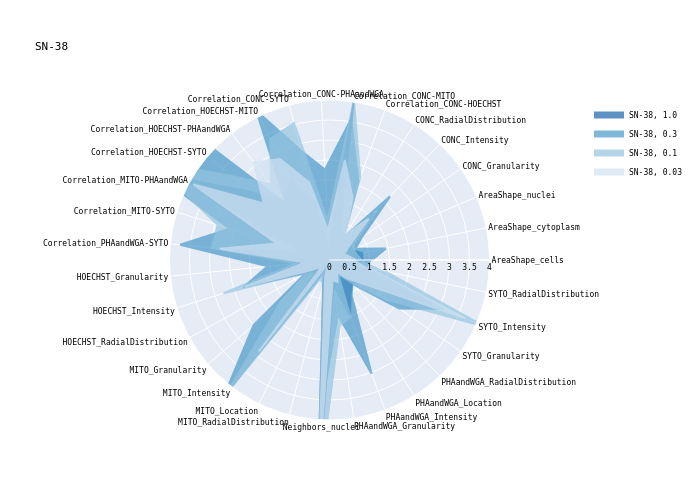

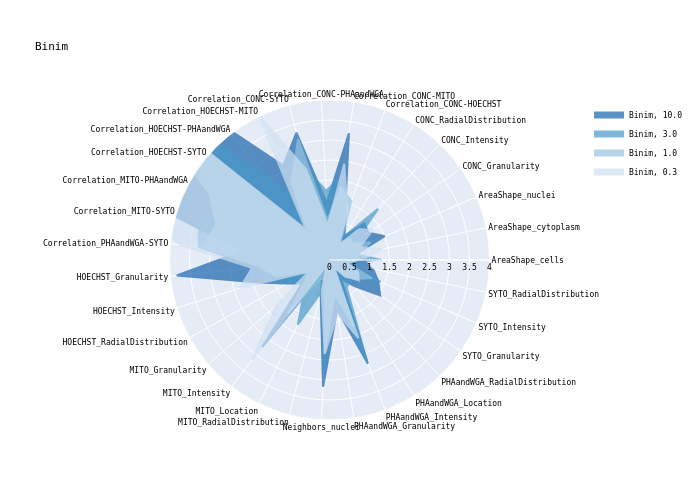

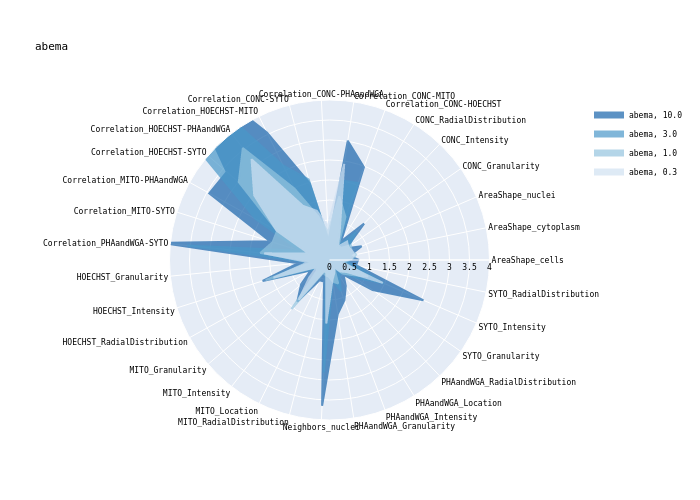

In [29]:
## Plot compound radarplots

color_palette = sns.color_palette(cmap,6).as_hex()

for compound in CompoundList:
    df_38cat_part = df_38cat[df_38cat['Metadata_name'] == compound].copy()
    doses = sorted(list(set(df_38cat_part['Metadata_cmpd_conc'])), reverse=True)

    traces = []
    for i, dose in enumerate(doses[:5]):
        try:
            color = color_palette[i % len(color_palette)]
            data_point = df_38cat_part.loc["{}_{}".format(compound, dose)]
            trace = go.Scatterpolar(
                r=data_point, theta=categories, fill='toself',
                opacity=0.7, line_color=color, fillcolor=color,
                connectgaps=True, name="{}, {}".format(compound, dose)
            )
            traces.append(trace)
        except: 
            print("Missing data for {}_{}".format(compound, dose))

    fig = go.Figure(data=traces, layout=go.Layout(
        title=go.layout.Title(text='{}'.format(compound)),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    ))

    fig.update_layout(
        polar=dict(radialaxis=dict(type="linear", range=[0, 4], tickangle=0)),
        showlegend=True,
        font=dict(family="Courier New, monospace", size=8, color="Black")
    )

    fig.show(renderer='png')
    fig.write_image("{}/radarplot_3D_{}_{}.pdf".format(OutputDir, compound, cell_line))


In [30]:
# # List compounds that are not controls
# RefList = selected_df.loc[selected_df['Metadata_pert_type'] != 'trt', 'Metadata_name'].unique()


In [31]:
# ## Plot reference radarplots

# color_palette = sns.color_palette(cmap,1).as_hex()

# for compound in RefList:
#     df_38cat_part = df_38cat[df_38cat['Metadata_name'] == compound].copy()
#     doses = sorted(list(set(df_38cat_part['Metadata_cmpd_conc'])), reverse=True)

#     traces = []
#     for i, dose in enumerate(doses[:6]):
#         try:
#             color = color_palette[i % len(color_palette)]
#             data_point = df_38cat_part.loc["{}_{}".format(compound, dose)]
#             trace = go.Scatterpolar(
#                 r=data_point, theta=categories, fill='toself',
#                 opacity=0.7, line_color=color, fillcolor=color,
#                 connectgaps=True, name="{}, {}".format(compound, dose)
#             )
#             traces.append(trace)
#         except: 
#             print("Missing data for {}_{}".format(compound, dose))

#     fig = go.Figure(data=traces, layout=go.Layout(
#         title=go.layout.Title(text='{}'.format(compound)),
#         polar={'radialaxis': {'visible': True}},
#         showlegend=True
#     ))

#     fig.update_layout(
#         polar=dict(radialaxis=dict(type="linear", range=[0, 4], tickangle=0)),
#         showlegend=True,
#         font=dict(family="Courier New, monospace", size=8, color="Black")
#     )


#     fig.show(renderer='png')
#     # fig.write_image("{}/radarplot_ref_{}_{}.png".format(OutputDir, compound, cell_line))


In [32]:
# df_38cat_part = df_38cat[df_38cat['Metadata_name'] == compound].copy()
# doses = sorted(list(set(df_38cat_part['Metadata_cmpd_conc'])), reverse=True)

# traces = []
# for i, dose in enumerate(doses[:6]):
#     try:
#         color = color_palette[i % len(color_palette)]
#         data_point = df_38cat_part.loc["{}_{}".format(compound, dose)]
#         trace = go.Scatterpolar(
#             r=data_point, theta=categories, fill='toself',
#             opacity=0.7, line_color=color, fillcolor=color,
#             connectgaps=True, name="{}, {}".format(compound, dose)
#         )
#         traces.append(trace)
#     except: 
#         print("Missing data for {}_{}".format(compound, dose))

# fig = go.Figure(data=traces, layout=go.Layout(
#     title=go.layout.Title(text='{}'.format(compound)),
#     polar={'radialaxis': {'visible': True}},
#     showlegend=True
# ))

# fig.update_layout(
#     polar=dict(radialaxis=dict(type="linear", range=[0, 4], tickangle=0)),
#     showlegend=True,
#     font=dict(family="Courier New, monospace", size=8, color="Black")
# )

# # Sample data for the pie chart
# labels = ['Category A', 'Category B', 'Category C']
# values = [30, 40, 30]

# # Create a pie chart trace
# pie_trace = go.Pie(
#     labels=labels,
#     values=values,
#     hole=0.9, 
#     opacity=0.7,
# )

# # Add the pie chart trace to your existing figure
# fig.add_trace(pie_trace)


# # Set figure size
# fig.update_layout()

# # fig.show(renderer='png')